# Analysis of a graph struture and information efficiency

**Thématique :** Copmplex Systems / Computational Neuroscience
**Tools :** Information Theory (Transfert Entropy)
**Lien GitHub :** [ENSLProjects/Numerical_Project](https://github.com/ENSLProjects/Numerical_Project)


In [12]:
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

from bnn_package import evolution_vec, MSD, pos_nodes_uniform, connexion_normal_deterministic, MSD_inverse, connexion_normal_random_NUMBA, prepare_data


print('Matplotlib backend:', plt.get_backend())

 # --- PATCH DE COMPATIBILITÉ (Indispensable pour Numpy récent) ---
if not hasattr(np, 'int'):
    setattr(np, 'int', int)
if not hasattr(np, 'float'):
    setattr(np, 'float', float)

import entropy.entropy as ee

 

rng = np.random.default_rng(42) 

Matplotlib backend: module://matplotlib_inline.backend_inline


## Scientific Question

> **To what extent does the structure of a graph influence the efficiency of information transmission?**

**Aproach :**
1.  **Dynamic Model :** Use of simple chaotic équations (Hénon Map)
2.  **Mesurements :** Compare the **Connectivity matrix** and the **Transfert Entropy matrix**.
3.  **Hypothesis :** The maximum of the transfert entropy is at the **Critical Point**.

Hénon model: 
\begin{align}
    x_{n+1} &= y_n + 1 - ax_n^2\\
    y_{n+1} &= bx_n
\end{align}


When ading coupling between node i and j : 
\begin{align}
    (x^i_{n}) \leftarrow (1-\epsilon) x^i_{n} + \epsilon x^j_{n} \\
    (y^i_{n}) \leftarrow (1-\epsilon) y^i_{n} + \epsilon y^j_{n}
\end{align}

In [4]:
# --- HENON MAP AND BIFURCATION DIAGRAM FUNCTIONS ---pip install nbformat nbconvert autopep8


def henon_map(a, b, x0, y0, n):
    """
    Generate points of the Henon map
    """
    x, y = x0, y0
    points = np.zeros((n, 2))
    for i in range(n):
        x_new = 1 - a * x**2 + y
        y_new = b * x
        points[i, :] = [x_new, y_new]
        x, y = x_new, y_new
    return points



def bifurcation_diagram(a_values, b, x0, y0, n, last, axis):
    """
    Plot the bifurcation diagram of the Henon map
    """
    fig, ax = plt.subplots(figsize=(10, 6))
 
    if axis == "x":
        for a in a_values:
            points = henon_map(a, b, x0, y0, n)
            ax.scatter([a] * last, points[-last:, 0], s=0.5, c="blue")
    else:
        for a in a_values:
            points = henon_map(a, b, x0, y0, n)
            ax.scatter([a] * last, points[-last:, 1], s=0.5, c="blue")
    ax.set_title(f"Bifurcation Diagram (b={b})")
    ax.set_xlabel("a")
    ax.set_ylabel("x")
    ax.grid(True)
    plt.show()



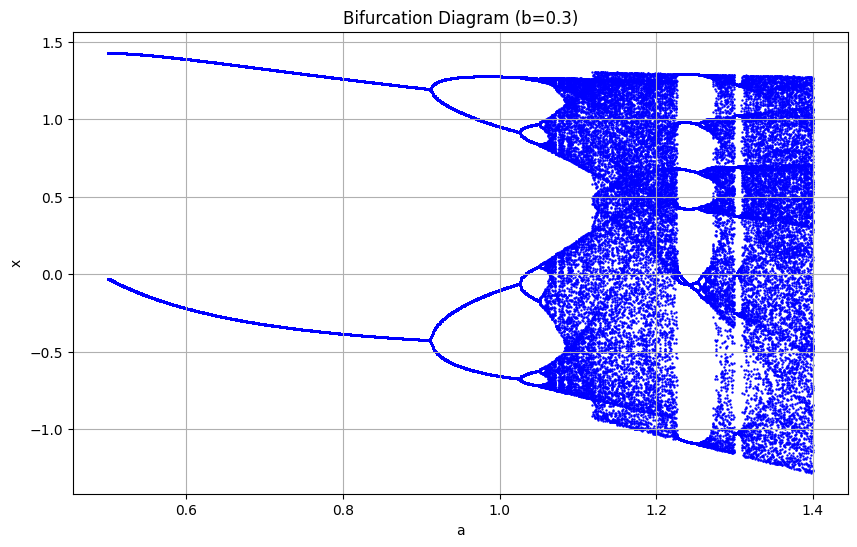

In [5]:

# Tracé du diagramme de bifurcation pour x
a_values = np.linspace(0.5, 1.4, 1000)
b = 0.3
x0, y0 = 0.1, 0.1
n = 1000
last = 100
bifurcation_diagram(a_values, b, x0, y0, n, last, axis="x")

## Goals : 
- **Find a phase transition :** Epsilon as a control parameter and MSD as an order parameter. 
\begin{align}
\text{<MSD>} = <\frac{1}{n} \sum_{i=1}^{n} \left[ (x_i(t) - \bar{x}(t))^2 + (y_i(t) - \bar{y}(t))^2 \right]>
\end{align}
- **Compute the Transfert Entropy :** Gives an idea on how X behaves knowing the behavior of Y. (H is the shanon entropy)
\begin{align}
TE_{Y \to X} =H(X_{n+1} | X_n^{(k)}) - H(X_{n+1} | X_n^{(k)}, Y_n^{(l)}) \\
\end{align}
- **Compare TE with de conectivity matrix :** As the correlation length diverges at criticallity. We want to show that the TE is maximal a this point.

## Technical Choices

**Language :** Python 3.13
- *Rich Scientific ecosystem*
- *Some Libraries use Cython (entropy)*

**Programmation Paradigms:** 
- **Modular :** Every part of the code can be changed (graph generator, dynamic, TE computation)

**User Interface :**
- Importable library for scripts.
- Demonstration notebooks for better understanding. 


## Example : Two body problem

- Lets find out what happens when we only have two connected bodies. 

(2, 2)


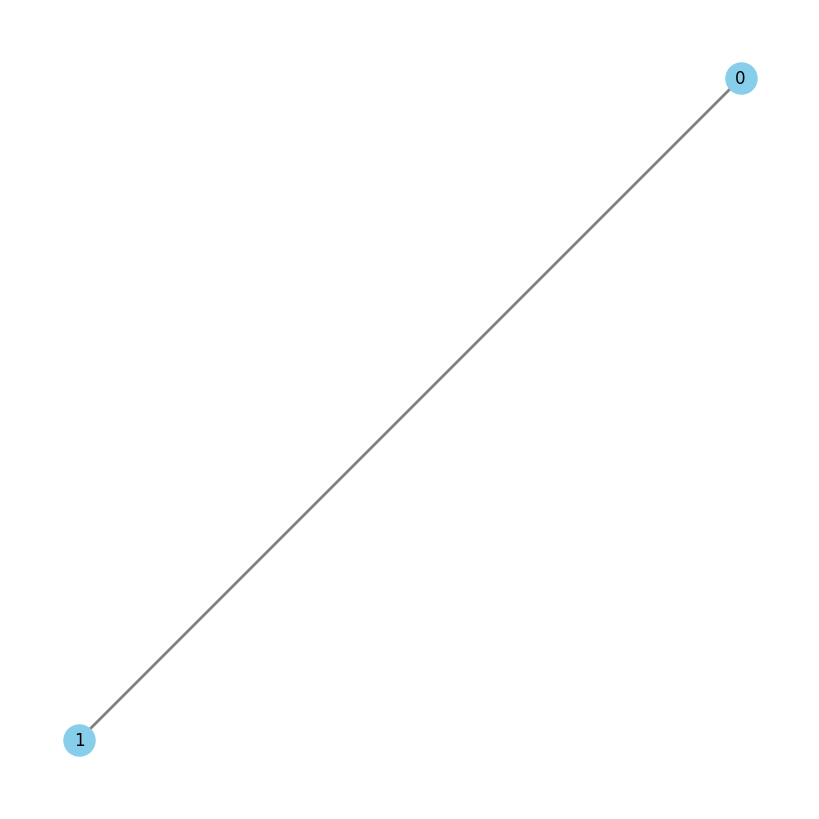

In [6]:
## Création des neuds dynamiques
Number_Nodes = 2
xmax=1
ymax=1
test_pos = pos_nodes_uniform(Number_Nodes, xmax, ymax, rng) # Random position of nodes 
POS = {i: (test_pos[0, i], test_pos[1, i]) for i in range(Number_Nodes)}
Adja = np.array([[0, 1], [1, 0]]) 
graphe = nx.from_numpy_array(Adja)
print(test_pos.shape)

# Affichage du graphe
plt.figure(figsize=(8, 8))
nx.draw(
    graphe, 
    pos=POS,  # Utilisation du dictionnaire de positions
    node_size=500,
    with_labels=True,
    node_color="skyblue",
    edge_color="gray",
    width=2.0
)



In [9]:

## Initialisation des paramètres

# Constants of the model
list_ab = np.zeros((2, Number_Nodes))
for i in range(Number_Nodes):
    list_ab[0, i] = rng.uniform(1.1, 1.4)
    list_ab[1, i] = 0.3

# Simulation parameters
T = 20000
Epsilon = np.linspace(0, 1, 400)
X_0 = [0.5 for _ in range(Number_Nodes)]
Y_0 = [0.5 for _ in range(Number_Nodes)]
transitoire = 15000


## Lancement de la simulation

Xevol_forward, Yevol_forward = (
    np.zeros((T, len(X_0), len(Epsilon))),
    np.zeros((T, len(X_0), len(Epsilon))),
)

for i in tqdm(range(len(Epsilon))):
    Xevol_forward[:, :, i], Yevol_forward[:, :, i] = evolution_vec(
        X_0, Y_0, T, list_ab, Epsilon[i], Adja
    )

print(Xevol_forward.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 87.81it/s]

(20000, 2, 400)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 6867.32it/s]

0.401456260436824


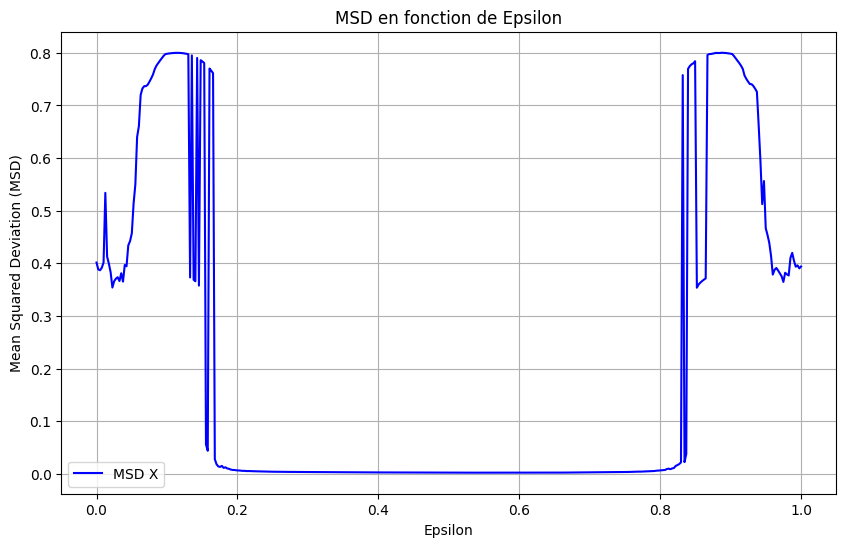

In [10]:
## Mesure de la MSD
msd_period_x = np.zeros(len(Epsilon))
for i in tqdm(range(len(Epsilon))):
    msd_period_x[i] = MSD(Adja, Xevol_forward[transitoire:, :, i], axe=1)
        
    
print(MSD(Adja, Xevol_forward[transitoire:, :, 0], axe=1))


# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(Epsilon, msd_period_x, label="MSD X", color="blue")
plt.xlabel("Epsilon")
plt.ylabel("Mean Squared Deviation (MSD)")
plt.title("MSD en fonction de Epsilon")
plt.legend()
plt.grid()
plt.show()

In [13]:
## Mesure de la TE 
te_period_x = np.zeros(len(Epsilon))
for i in tqdm(range(len(Epsilon))):
    x = prepare_data(Xevol_forward[transitoire:, 0, i])
    y = prepare_data(Xevol_forward[transitoire:, 1, i])
    te_period_x[i] = ee.compute_TE(x=x, y=y, k=3, N_eff=-1, lag = 4)[0]
 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.69it/s]


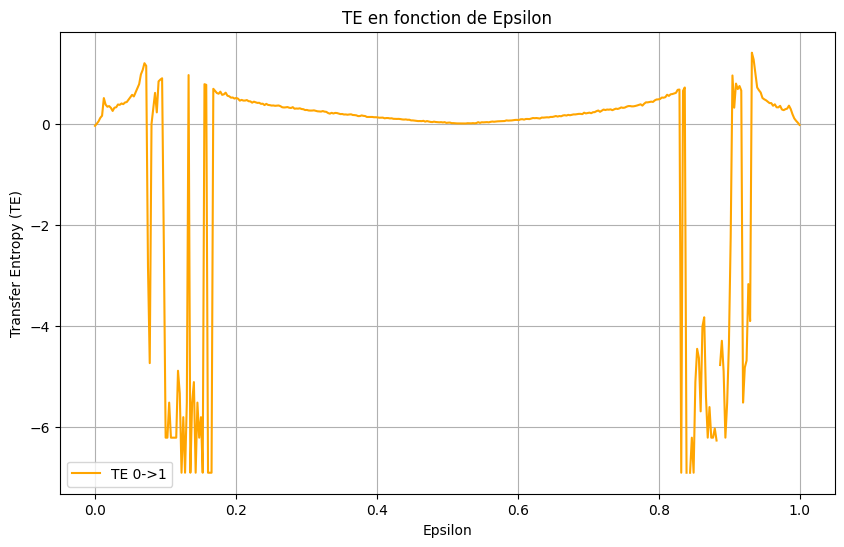

In [14]:

## Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(Epsilon, te_period_x, label="TE 0->1", color="orange")
plt.xlabel("Epsilon")
plt.ylabel("Transfer Entropy (TE)")
plt.title("TE en fonction de Epsilon")
plt.legend()
plt.grid()
plt.show()


